## More Randomised Benchmarking ##

In [ ]:
import random
import math
import numpy as np

import copy


import sys, os, time

from qinfer import LiuWestResampler
from qinfer import utils

from qiskit import IBMQ
from qiskit import QuantumCircuit, execute, Aer
import qiskit.ignis.verification.randomized_benchmarking as rb

IBMQ.load_account()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sbs

import smc_linear as smc
Distribution = smc.Distribution

sbs.set(style="darkgrid")

%matplotlib inline

Applies an inv arr string to an existing circuit

In [ ]:
def design_circuit(n_qubits, inv_arr, circuit=None):
    
    if circuit is None:
        circuit = QuantumCircuit(n_qubits, n_qubits)
    
    for i, element in enumerate(inv_arr):
        if element == 1:
            circuit.x(i)
    
    circuit.measure(list(range(n_qubits)), list(range(n_qubits)))
    return circuit

Construct a random circuit 

In [ ]:
def random_circuit(n_qubits):
    length_vector = [1]
    n_seeds = 1
    
    initial_list = list(range(0, n_qubits))    
    rb_pattern = []
    
    while len(initial_list) > 1:
        sample = random.sample(initial_list, 2)
        [initial_list.remove(i) for i in sample]
        rb_pattern.append(sample)
    
    if len(initial_list) == 1:
        rb_pattern.append([initial_list[0]])
    
    
    circuit, xdata = rb.randomized_benchmarking_seq(
        length_vector = [1],
        nseeds = 1,
        rb_pattern = rb_pattern
        )
    circuit = circuit[0][0]
    cregs = circuit.cregs
    
    circuit.remove_final_measurements(inplace=True)
    circuit.cregs = cregs
    
    for i in range(n_qubits):
        circuit.barrier(i)
        if (round(random.random())):
            circuit.x(i)
            circuit.barrier(i)
    
    return circuit

In [ ]:
provider = IBMQ.get_provider(group='open', project='main')
backend = provider.get_backend('ibmq_16_melbourne')

n_qubits = 15

n_measurements = 200
n_experiments = 20
n_points = 2000

results = []

for i in range(n_experiments):    

    result_data = {}
    
    circuit = random_circuit(n_qubits)

    result_data['circuit'] = circuit
    result_data['risk'] = []
    result_data['mean'] = []
    result_data['len'] = len(circuit)
    
    dist = Distribution(n_points=n_points, n_qubits=n_qubits)

    for _ in range(n_measurements):
        
        inversion_arr = dist.next_experiment()       
        
        tmp_circuit = copy.deepcopy(circuit)
        tmp_circuit = design_circuit(n_qubits, inversion_arr, circuit=tmp_circuit)

        job = execute(tmp_circuit, backend, shots=1)
        
        result = job.result()
        outcome = list(map(int, list(list(result.get_counts(circuit).keys())[0])))     
        
        print("Measurements: {} Outcome: {}".format(inversion_arr, outcome))
        dist.measure(outcome, inversion_arr)
        
        result_data['risk'].append(dist.calc_bayes_risk())
        result_data['mean'].append(dist.calc_bayes_mean())

    
    result_data['distrubtion'] = dist
    results.append(result_data)


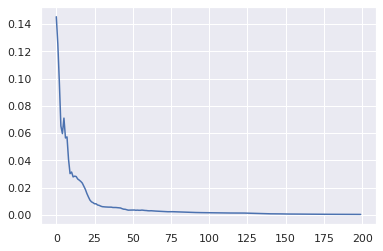

In [29]:
plt.plot(results[0]['risk'])

In [ ]:
init_res = []
final_res = []
for res in results:
    
    init_circuit = copy.deepcopy(res['circuit'])
    init_circuit = design_circuit(n_qubits, [0] * n_qubits, circuit=init_circuit)
    
    inv_arr = res['mean'][-1]
    
    final_circuit = copy.deepcopy(i['circuit'])
    final_circuit = design_circuit(n_qubits, inv_arr, circuit=final_circuit)
    
    init_job = execute(init_circuit, backend, shots=4096)
    init_result = init_job.result()
    init_res.append(init_result.get_counts(circuit))
    
    final_job = execute(final_circuit, backend, shots=4096)
    final_result = final_job.result()
    final_res.append(final_result.get_counts(circuit))
    

In [ ]:
def bootstrap(result, samples=900, repeats=1000):
    sampler = []
    for i in result:
        for _ in range(result[i]):
            sampler.append(int(i))
            
    target = int(max(result.keys(), key=lambda key: result[key]))
    
    probs = []
    
    for _ in range(repeats):
        tally = 0
        for i in range(samples):
            sample = sampler[random.randint(0, len(sampler) - 1)]
            
            if sample == target:
                tally += 1
        
        probs.append(tally / samples)
    return probs

In [ ]:
results[0]['circuit'].draw()

In [ ]:
samples = 64
n_repeats = 64

x_coords = np.array([[len(res['circuit'])] * n_repeats for res in results]).flatten()
y_coords_init = 1 - np.array([bootstrap(res, samples=samples, repeats=n_repeats) for res in init_res]).flatten()


y_coords_final = 1 - np.array([bootstrap(res, samples=samples, repeats=n_repeats) for res in final_res]).flatten()

sbs.lineplot(x_coords, y_coords_init)
sbs.lineplot(x_coords, y_coords_final)

plt.ylabel('Error Rate')
plt.xlabel('Circuit Depth')